In [1]:
# Import modules
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Setup system path to import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import StockDataset
from utils import TICKERS, predict_direction, predict_close
import metrics as mymetrics
import graph_utils as graph

In [2]:
### Let's test some different hyperparameters for direction prediction

# Build and split dataset. We'll use MSFT to test for best hyperparameters
ds = StockDataset(tickers='MSFT', delta=1, keep_volume=False)
t_data, v_data, t_label, v_label = ds.split(label_field='Direction')

print('Train data shape:', t_data.shape)
print('Val data shape:', v_data.shape)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Initializing data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]

Done.
Train data shape: (994, 6)
Val data shape: (248, 6)


In [3]:
# Set hyperparameters to test
hyperparameters = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# Build direction classifier with 1000 estimators
direction_clf = KNeighborsClassifier()

# Use built-in sklearn class to test different hyperparameters (may take awhile)
grid_search = GridSearchCV(direction_clf, hyperparameters, n_jobs=2, verbose=3).fit(t_data, t_label)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    3.6s finished


In [4]:
# Get best parameters
best_params = grid_search.best_params_
k = best_params['n_neighbors']
weights = best_params['weights']
p = best_params['p']

In [5]:
### Now let's see how we do on all 10 stocks

# Build a classifier with our discovered parameters
clf = KNeighborsClassifier(n_neighbors=k, weights=weights, p=p)

# Use our previously created function to predict the direction
direction_results = predict_direction(clf, TICKERS, delta=1, keep_volume=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


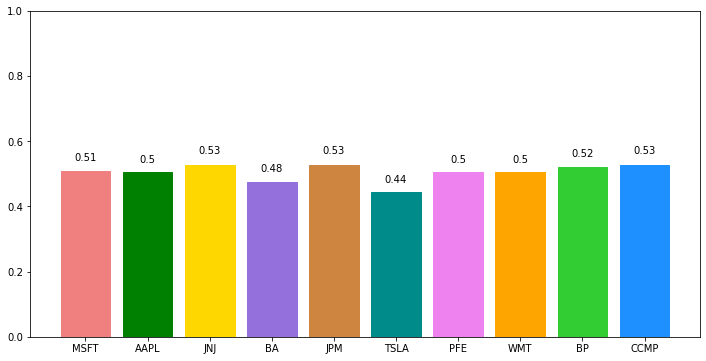

In [6]:
# And let's plot the accuracy for each ticker
graph.plot_direction_accuracy(direction_results)

In [7]:
### Now let's see how we do on closing prices

# Build and split dataset. We'll use MSFT to test for best hyperparameters
ds = StockDataset(tickers='MSFT', keep_volume=False, add_derivatives=False)
t_data, v_data, t_label, v_label = ds.split(label_field='Direction')

print('Train data shape:', t_data.shape)
print('Val data shape:', v_data.shape)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Initializing data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

Done.
Train data shape: (1006, 4)
Val data shape: (251, 4)


In [8]:
# Set hyperparameters to test
hyperparameters = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# Build direction classifier with 1000 estimators
direction_clf = KNeighborsRegressor()

# Use built-in sklearn class to test different hyperparameters (may take awhile)
grid_search = GridSearchCV(direction_clf, hyperparameters, n_jobs=2, verbose=3).fit(t_data, t_label)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.9s finished


In [9]:
# Get best parameters
best_params = grid_search.best_params_
k = best_params['n_neighbors']
weights = best_params['weights']
p = best_params['p']

In [10]:
### And let's try it for all 10 stocks

# Build a classifier with our discovered parameters
clf = KNeighborsRegressor(n_neighbors=k, weights=weights, p=p)

# Use our previously created function to predict the direction
close_results = predict_close(clf, TICKERS, keep_volume=False, add_derivatives=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]


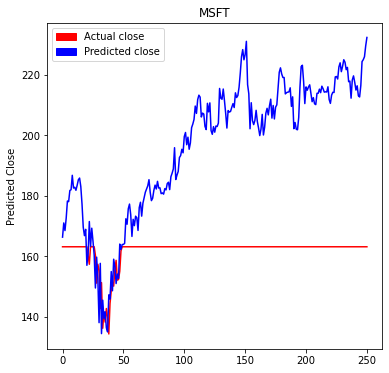

In [11]:
# Let's visualize how we did predicting the closing price of Microsoft
v_pred = close_results['MSFT']['v_pred']
v_true = close_results['MSFT']['v_true']
graph.plot_predicted_close('MSFT', v_pred, v_true)

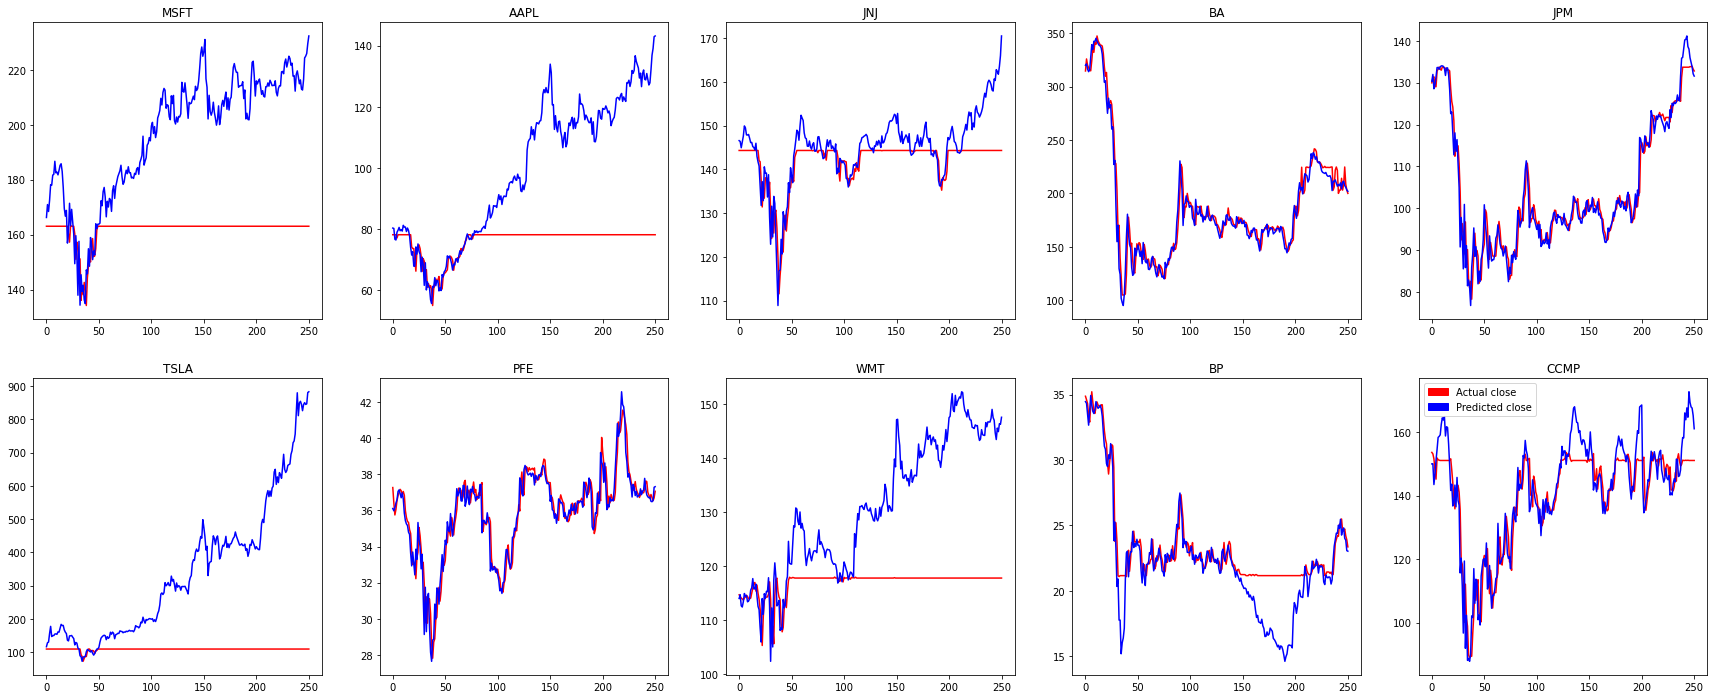

In [12]:
# Not bad. Now let's see how we do on all 10 stocks
graph.plot_all_predicted_close(close_results)

In [13]:
# One last thing to check is the mean absolute percentage error of our predictions

# Loop through the tickers and get the MAPE for each
mapes = {}
for ticker in close_results:
    pred = close_results[ticker]['v_pred']
    true = close_results[ticker]['v_true']
    
    # Remove top 5% of predictions (out of sample)
    k = pred.max() - (0.05 * (pred.max() - pred.min()))
    
    # Compute MAPE
    mape = mymetrics.mean_absolute_percentage_error(true, pred, max_threshold=k)
    
    # Store it in the dictionary
    mapes[ticker] = mape

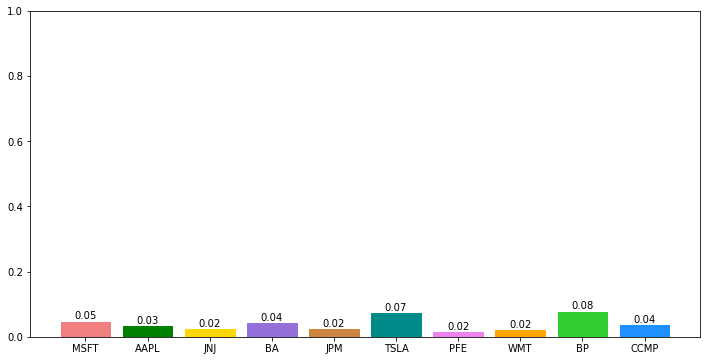

In [14]:
# And now let's plot the MAPE (we can use the same function as for direction)
graph.plot_direction_accuracy(mapes)